# Subreddit Classification Through NLP - Science or Social Science?

## Introduction & Problem Statement

Natural Language Processing (NLP) is a field of artificial intelligence which involves the use of machine learning to help computers understand natural language data. NLP has a wide range of applications including speech recognition, sentiment analysis, argument mining & automatic summarisation. In this project, we will be exploring the NLP task of making predictions based on the text contents of a corpus.

A major source of unstructured natural language data are social media websites such as Reddit, where users create posts in communities known as subreddits. Specifically, we will be working with the contents of posts from two different subreddits - `r/AskScience` and `r/AskSocialScience`.

**Problem Statement:
How can we best develop a classification model using NLP to classify posts belonging to two different subreddits?**

Both subreddits serve as forums for answering questions about their respective fields - Science & Social Science. The majority of posts come in the form of questions about something related to the field, which would then be answered by other users in the comments. In this project, we will only be focusing on the text contents of the original post itself, including the title and the self-text of the post. 

At first glance, both subreddits seem to be quite similar in that their functions are identical and the fields are not too different from each other. Through various NLP techniques, we will attempt to train a model that will be able to identify the differences between posts from each subreddit and classify new posts accordingly. While the actual model may not have any practical use in real life (since Reddit posts are by default already assigned to whichever subreddit they are posted in), the insights gained from our analysis and processing may be useful to the moderators of the respective subreddits.

## Contents:
- [Scraping Reddit](#Scraping-Reddit)
- [Data Cleaning](#Data-Cleaning)
- [Text Preprocessing](#Text-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Exporting Cleaned & Preprocessed Data](#Exporting-Cleaned-&-Preprocessed-Data)

In [118]:
# Necessary imports
import pandas as pd
import numpy as np
import time
import random
%matplotlib inline

import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
from wordcloud import WordCloud

## Scraping Reddit

We will be using Reddit's API to collect posts from the two subreddits. However, it is not simply a matter of accessing the API and downloading the first 1000 posts. We would have to successively call on Reddit's API (as it will only give us 25 posts per request) whilst maintaining some sort of false identity to avoid being locked out by their anti-bot systems.

In [16]:
# Importing list of random words
with open('../data/random_word_list') as word_doc:
    words = [line.strip() for line in word_doc]

In [21]:
# Randomised user agent example
random.choice(words).capitalize() + ' ' + random.choice(words).capitalize()

'Gothic Function'

### Subreddit 1 - `r/askscience`

In [108]:
url = 'https://www.reddit.com/r/askscience.json'

In [109]:
# Create empty dataframe to store posts
current_df = pd.DataFrame(columns=['title'])

In [110]:
current_df.to_csv('../data/askscience_raw.csv')

In [111]:
posts = []
after = None

# Retrieve latest 1000 posts
while current_df['title'].notnull().sum() < 1000:
    if after == None:
        current_url = url
    else:
        current_url = url + '?after=' + after
    print(current_url)
    
    user_agent = random.choice(words).capitalize() + ' ' + random.choice(words).capitalize()
    res = requests.get(current_url, headers={'User-agent': user_agent})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']] 
    posts.extend(current_posts)
    after = current_dict['data']['after']
    
    pd.DataFrame(posts).to_csv('../data/askscience_raw.csv', index = False)
    current_df = pd.read_csv('../data/askscience_raw.csv')

    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(4,8)
    print(f'Sleep Duration: {sleep_duration}')
    print(f"Posts collated: {len(current_df)}, Posts with selftext: {current_df['selftext'].notnull().sum()}")
    time.sleep(sleep_duration)

### Subreddit 2 - `r/asksocialscience`

In [113]:
url = 'https://www.reddit.com/r/asksocialscience.json'

In [114]:
# Create empty dataframe to store posts
current_df = pd.DataFrame(columns=['title'])

In [115]:
current_df.to_csv('../data/asksocialscience_raw.csv')

In [116]:
posts = []
after = None

# Retrieve latest 1000 posts
while current_df['title'].notnull().sum() < 1000:
    if after == None:
        current_url = url
    else:
        current_url = url + '?after=' + after
    print(current_url)
    
    user_agent = random.choice(words).capitalize() + ' ' + random.choice(words).capitalize()
    res = requests.get(current_url, headers={'User-agent': user_agent})
    
    if res.status_code != 200:
        print('Status error', res.status_code)
        break
    
    current_dict = res.json()
    current_posts = [p['data'] for p in current_dict['data']['children']] 
    posts.extend(current_posts)
    after = current_dict['data']['after']
    
    pd.DataFrame(posts).to_csv('../data/asksocialscience_raw.csv', index = False)
    current_df = pd.read_csv('../data/asksocialscience_raw.csv')

    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(4,8)
    print(f'Sleep Duration: {sleep_duration}')
    print(f"Posts collated: {len(current_df)}, Posts with selftext: {current_df['selftext'].notnull().sum()}")
    time.sleep(sleep_duration)

## Data Cleaning

In [47]:
sci = pd.read_csv(
    '../data/askscience_raw.csv',
    usecols=['subreddit', 'selftext', 'title', 'author']
)
socsci = pd.read_csv(
    '../data/asksocialscience_raw.csv', 
    usecols=['subreddit', 'selftext', 'title', 'author']
)

### Duplicates

There are duplicates in our data mainly due to two reasons:
1. Overlap of posts between requests due to creation of a new post
2. Reddit's security system resetting the cycle for the API calls

We will drop the duplicate posts based on the title text.

In [48]:
sci.drop_duplicates(subset='title', inplace=True)

In [49]:
socsci.drop_duplicates(subset='title', inplace=True)

### Null Imputation

Some selftext fields are null due to the posts consisting solely of an image or video. We will impute these with blank strings.

In [50]:
sci.fillna(value='', inplace=True)

In [51]:
socsci.fillna(value='', inplace=True)

### Moderator Posts

Moderator posts can be quite systematic and some posts are repeated on a weekly or monthly basis. These posts may not be representative of the actual content of regular posts within the subreddit. We will explore the contents of these moderator posts for each subreddit.

In [52]:
sci.loc[(sci['author'] == 'AskScienceModerator') | (sci['author'] == 'AutoModerator')]

,subreddit,selftext,title,author
0,askscience,**Please read this entire post carefully and f...,AskScience Panel of Scientists XXIV,AskScienceModerator
1,askscience,**TL;DR:** Last week was British Science Week!...,AskScience AMA Series: Hi Reddit - we are grou...,AskScienceModerator
12,askscience,Happy Pi Day! It's March 14 (3/14 in the US) w...,Pi Day Megathread 2021,AskScienceModerator
50,askscience,Is there a connection between what you eat and...,AskScience AMA Series: We are experts looking ...,AskScienceModerator
108,askscience,"Welcome to our weekly feature, Ask Anything We...","Ask Anything Wednesday - Engineering, Mathemat...",AutoModerator
180,askscience,Hi Reddit! We just published a study on live t...,AskScience AMA Series: We're neuroscientists a...,AskScienceModerator
220,askscience,"Hi! I am Tel Aviv University cancer biologist,...",AskScience AMA Series: Hi! I am Tel Aviv Unive...,AskScienceModerator
225,askscience,"Welcome to our weekly feature, Ask Anything We...","Ask Anything Wednesday - Physics, Astronomy, E...",AutoModerator
226,askscience,"Hi Reddit! I'm Herman Pontzer, PhD, Associate ...","AskScience AMA Series: I'm Herman Pontzer, an ...",AskScienceModerator
343,askscience,We will be answering your questions related to...,AskScience AMA Series: Hello Reddit! For Medsc...,AskScienceModerator


`r/askscience` has two regular moderator accounts. We can see that posts from `AskScienceModerator` are actually quite distinct from one another, varying based on different guests doing AMA sessions or the occurence of special events. `AutoModerator` on the other hand automatically creates repetitive posts on a weekly basis, so we will be removing these.

In [53]:
socsci.loc[socsci['author'] == 'AutoModerator']

,subreddit,selftext,title,author
0,AskSocialScience,MONDAY RESEARCH AND READING: Monday Reading an...,"Monday Reading and Research | March 15, 2021",AutoModerator
1,AskSocialScience,Theory Wednesday topics include:\n\n\* Social ...,"Theory Wednesday | March 10, 2021",AutoModerator
20,AskSocialScience,This is for social science related outpourings...,"Friday Free-for-All | March 12, 2021",AutoModerator
34,AskSocialScience,MONDAY RESEARCH AND READING: Monday Reading an...,"Monday Reading and Research | March 08, 2021",AutoModerator
44,AskSocialScience,This is for social science related outpourings...,"Friday Free-for-All | March 05, 2021",AutoModerator
...,...,...,...,...
902,AskSocialScience,This is for social science related outpourings...,"Friday Free-for-All | August 14, 2020",AutoModerator
911,AskSocialScience,Theory Wednesday topics include:\n\n* Social s...,"Theory Wednesday | August 12, 2020",AutoModerator
917,AskSocialScience,MONDAY RESEARCH AND READING: Monday Reading an...,"Monday Reading and Research | August 10, 2020",AutoModerator
930,AskSocialScience,This is for social science related outpourings...,"Friday Free-for-All | August 07, 2020",AutoModerator


For `r/AskSocialScience`, the only moderator account creating posts is `AutoModerator`. Similar to above, we will be removing these repeated weekly posts.

In [54]:
sci.drop(sci.loc[sci['author'] == 'AutoModerator'].index, inplace=True)

In [55]:
socsci.drop(socsci.loc[socsci['author'] == 'AutoModerator'].index, inplace=True)

## Text Preprocessing

The raw text data that we have scraped from the subreddits are still quite messy. In order for them to be able to be put into the model, we will have to preprocess the data. 

### Stop Words

There are certain words that we would want to remove from the data, and can be split into two categories:

1. Overly descriptive words

    These are words that can be considered as 'dead giveaways', i.e. words that have an extremely strong correlation to one of the labels. These might not be helpful for our model as they do not provide much information to the end user, despite probably having high predictive values. For this project, we will just be removing the actual subreddit names.
    
    
2. Stop Words

    On the other end of the spectrum, there are stopwords that occur too frequently and do not provide any meaningful information to our model. These are commonly used words such as `this`, `is` and `not`. We can use the default list of stop words from the CountVectorizer transformer and add in more stopwords as we deem fit. These include words that may occur frequently in this particular dataset due to the content of both subreddits comprising mainly academic questions.

In [56]:
over_desc_words = ['askscience', 'asksocialscience']
extra_stop_words = ['http', 'https', 'www', 'reddit', 'com', 'r', 'ama', 'series',
                   'question', 'doe', 'does', 'like', 'user', 'know', 'way', 'just',
                   've', 'don', 'use']

In [57]:
# Creating list of stop words
stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
stopwords.extend(over_desc_words + extra_stop_words)

# For second layer of filtering
stemmed_stopwords = [PorterStemmer().stem(sw) for sw in stopwords]

### Preprocessing Raw String Data

Preprocessing consists of several steps:

1. Cleaning text
    1. html tags (if present) & links
    2. Reddit usernames
    3. Non-alphanumeric & new-line characters
2. Converting each word to lower case
3. Filtering out stopwords
4. Stemming each word to its base form

In [58]:
# Creating list of strings for each subreddit (combine selftext & title)
sci['comb'] = sci['selftext'] + ' ' + sci['title']
socsci['comb'] = socsci['selftext'] + ' ' + socsci['title']
sci_raw = sci['comb'].tolist()
socsci_raw = socsci['comb'].tolist()

In [59]:
# Creating function to preprocess list of raw strings
def preprocess(raw_input):
    # Input is list of raw strings
    # Output is list of preprocessed strings
    cleaned_output = []
    
    # Looping through each raw string
    for raw_string in raw_input:
        clean_string_words = []
        
        # Remove HTML tags & links
        remove_tags = BeautifulSoup(raw_string).get_text()
        remove_html = re.sub(
            r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',
            ' ',
            remove_tags, 
            flags=re.MULTILINE
        )
        
        # Remove reddit usernames
        remove_users = re.sub('u/[A-Za-z0-9_-]+', ' ', remove_html)
        
        # Remove non-alphanumeric & new line characters
        alphanumeric = re.sub('[\W\\n]', ' ', remove_users)
        
        # Convert to lower case, split into list of individual words
        words = alphanumeric.lower().split()
        for word in words:
            # Filtering out stopwords
            if word not in stopwords:
                stemmed_word = PorterStemmer().stem(word)
                # Second layer of filtering
                if stemmed_word not in stemmed_stopwords:
                    clean_string_words.append(stemmed_word)
        
        # Join back into one clean string & append to list of cleaned strings
        clean_string = " ".join(clean_string_words)
        cleaned_output.append(clean_string)
        
    return cleaned_output

In [60]:
clean_sci = preprocess(sci_raw)
clean_socsci = preprocess(socsci_raw)

## Exploratory Data Analysis

We can try and visualise some aspects of the unstructured data to gather some insights, which may help in our analysis & evaluation later on.

### Frequency of n-grams

An n-gram is a contiguous sequence of `n` words within a given sample of text. We will explore the most frequent n-grams from each subreddit to see if there are any noticeable patterns.

In [62]:
# Reset index due to earlier dropped rows
sci_df = pd.DataFrame(clean_sci, columns=['clean_text']).join(sci.reset_index()['subreddit'])
socsci_df = pd.DataFrame(clean_socsci, columns=['clean_text']).join(socsci.reset_index()['subreddit'])

In [110]:
# Create function to display most frequent n-grams from each subreddit
def plot_ngrams(ngram_range, top_n, figsize=(15,6)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax = ax.ravel()
    
    # Function to obtain top_n most frequent n-grams
    def get_most_freq_words(subreddit_df):
        # Instantiate vectorizer to tokenize text
        cvec = CountVectorizer(ngram_range=ngram_range)
        # Transform corpus into bag of words
        bow = cvec.fit_transform(subreddit_df['clean_text'])
        # Obtain list of ngrams sorted by frequency
        sum_words = bow.sum(axis=0)
        ngrams_freq = [(word, sum_words[0, idx]) for word, idx in cvec.vocabulary_.items()]
        ngrams_freq = sorted(ngrams_freq, key = lambda x: x[1], reverse=True)
        # Return top n most frequent ngrams
        return ngrams_freq[:top_n]
    
    # r/askscience
    sns.barplot(
        data=pd.DataFrame(get_most_freq_words(sci_df), columns=['ngram', 'frequency']),
        orient='h',
        x='frequency',
        y='ngram',
        ax=ax[0],
        palette='flare'
    )
    ax[0].set_title(f'r/AskScience Top {top_n} n-grams (Range: {ngram_range})', fontsize=16)
    
    # r/asksocialscience
    sns.barplot(
        data=pd.DataFrame(get_most_freq_words(socsci_df), columns=['ngram', 'frequency']),
        orient='h',
        x='frequency',
        y='ngram',
        ax=ax[1],
        palette='crest'
    )
    ax[1].set_title(f'r/AskSocialScience Top {top_n} n-grams (Range: {ngram_range})', fontsize=16)
    ax[1].set_ylabel('')

    fig.tight_layout()

#### Most Frequent Words

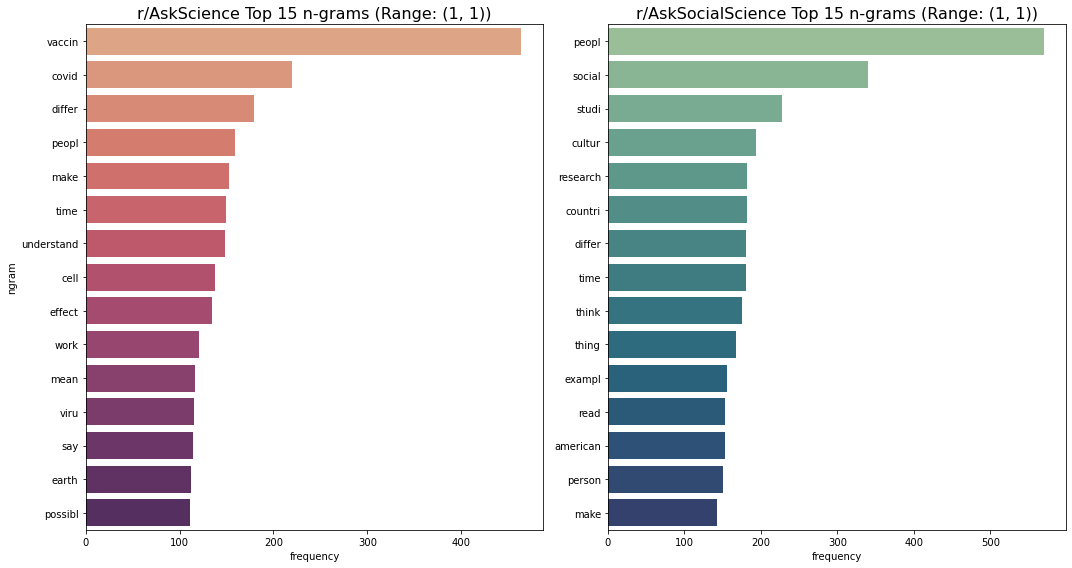

In [112]:
plot_ngrams((1,1), 15, figsize=(15,8))

Immediately, we can see that there is quite a lot of difference between the most frequent words of each subreddit. Despite having similar purposes, there are only 4 common stemmed words in the top 15 - `differ`, `peopl`, `make` and `time`. These seem to be rather common words that are not very indicative of the differences between the two subreddits.

`r/AskScience` seems to be dominated by the most prevalent topic in the world for the past year, COVID-19. Stemmed words such as `vaccin`, `covid`, `cell`, `effect` and `viru` are related to the epidemic. Meanwhile, `r/AskSocialScience` is heavily populated with words that seem to be the first things that come to mind when thinking about social science - `peopl`, `cultur` and `countri`. Surprisingly, `research` appears more on `r/AskSocialScience` than it does on `r/AskScience`.

#### Most Frequent Word Pairs

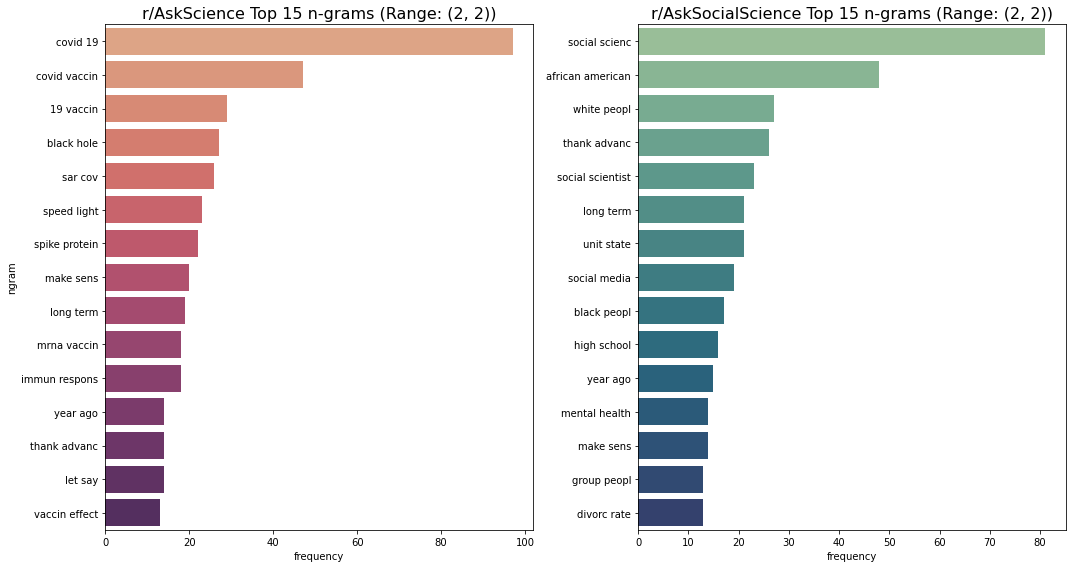

In [113]:
plot_ngrams((2,2), 15, figsize=(15,8))

Once we get into the word pairs, things seem to become even more interesting. As before, `r/AskScience` is dominated by Covid-19 related word pairs such as `covid 19`, `covid vaccin` and `vaccin effect`. Some other interesting scientific terms also appear, such as `black hole` and `speed light`. `r/AskSocialScience`, on the other hand, has more diverse frequent word pairs. Many are related to race (e.g. `white peopl`, `black peopl`, `african american`) while other topics such as `mental health` and `divorc rate` also appear.

#### Most Frequent Word Trios

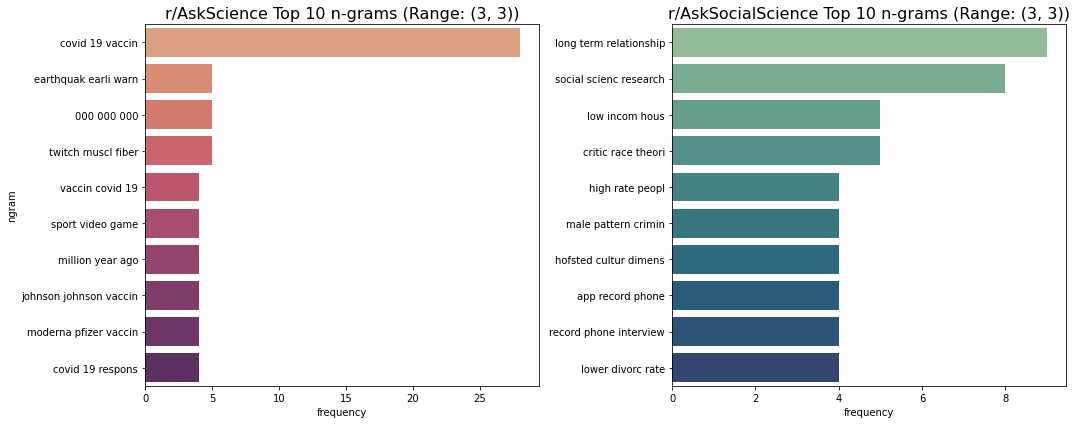

In [116]:
plot_ngrams((3,3), 10)

The list of most frequent n-grams starts to get very diverse once we get into word trios. Besides the hot topic of `covid 19 vaccin`, the n-grams for both subreddits appear less than 10 times in total. We can observe certain scientific topics related to word trios such as `earthquak earli warn` and `twitch muscl fiber` for `r/AskScience`, while `r/AskSocialScience` is full of phrases related to social issues, such as `low incom hous`, `lower divorc rate` and `male patter crimin`.

### Exploratory Word Clouds

We can further visualise the frequency of stemmed words by using a word cloud.

In [120]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off');

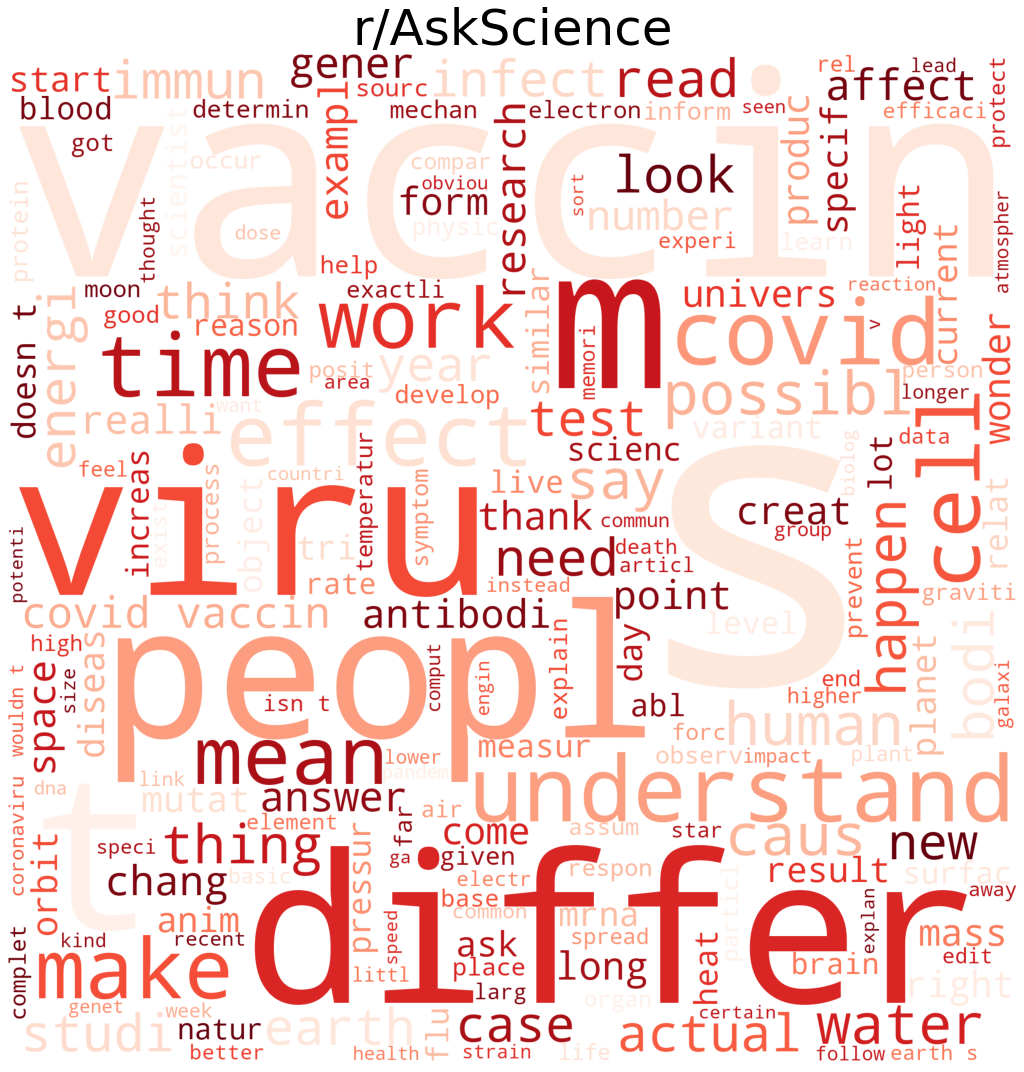

In [131]:
# r/AskScience Word Cloud
sci_wc = WordCloud(
    width=2000,
    height=2000,
    random_state=42,
    background_color='white',
    colormap='Reds'
).generate(' '.join(clean_sci))

plot_cloud(sci_wc)
plt.title('r/AskScience', fontsize=50)
plt.tight_layout();

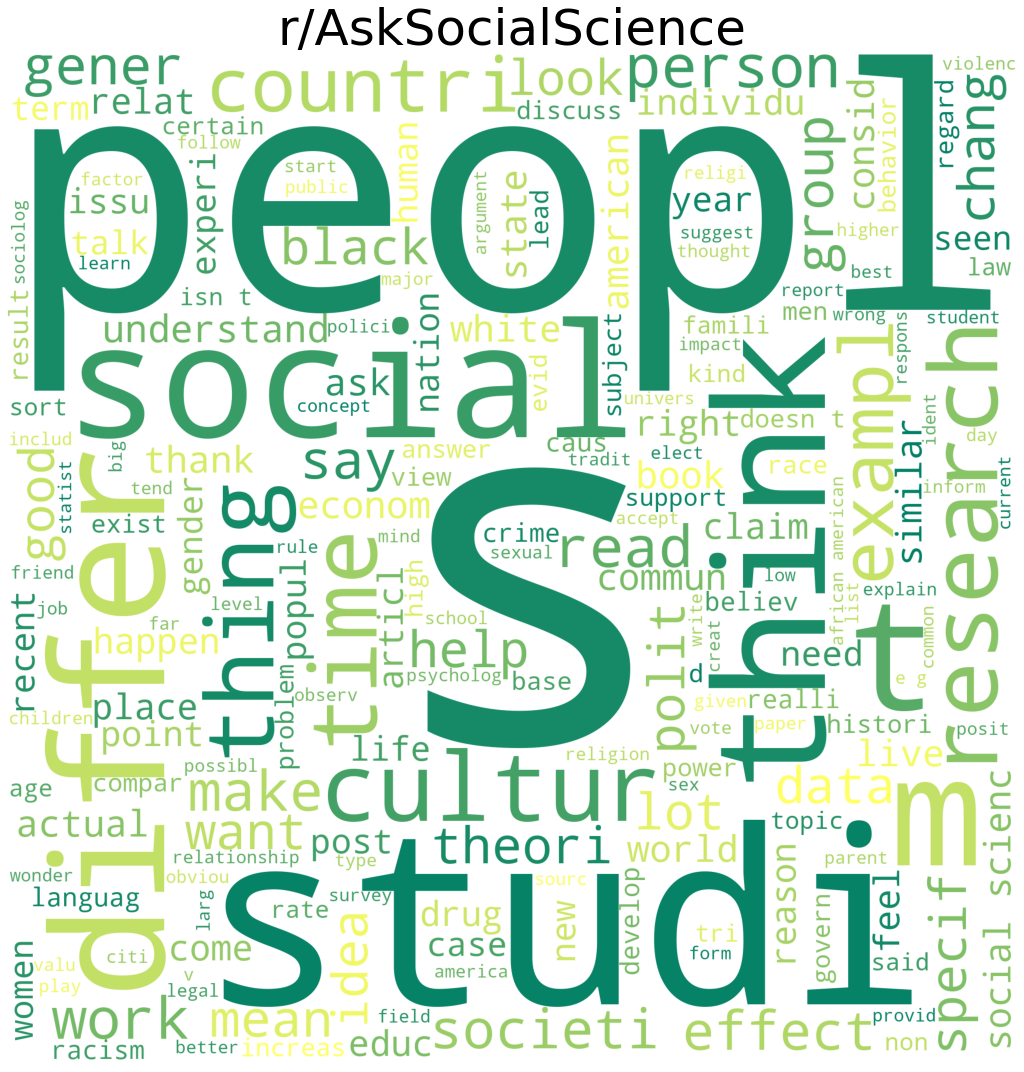

In [130]:
# r/AskSocialScience Word Cloud
socsci_wc = WordCloud(
    width=2000,
    height=2000,
    random_state=42,
    background_color='white',
    colormap='summer'
).generate(' '.join(clean_socsci))

plot_cloud(socsci_wc)
plt.title('r/AskSocialScience', fontsize=50)
plt.tight_layout();

## Exporting Cleaned & Preprocessed Data

In [63]:
# Combining data from both subreddits
comb_df = sci_df.append(socsci_df, ignore_index=True)

In [168]:
comb_df.to_csv('../data/combined_clean.csv', index=False)